# Hurricane Damage Detector

## Get and Load Dataset

In [1]:
!pip install --upgrade --no-cache-dir gdown

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for gdown: filename=gdown-4.4.0-py3-none-any.whl size=14774 sha256=a8e097fce5424d1950083f8b646f22264aee13d7733a10d062dc42c4cd900584
  Stored in directory: /tmp/pip-ephem-wheel-cache-zxg6vw0t/wheels/fb/c3/0e/c4d8ff8bfcb0461afff199471449f642179b74968c15b7a69c
Successfully built gdown
  Attempting uninstall: gdown
    Found existing installation: gdown 4.2.2
    Uninstalling gdown-4.2.2:
      Successfully uninstalled gdown-4.2.2


In [2]:
!gdown --id 1pByxsenTnJGBKnKhLTXBqbUN_Kbm7PNK

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1pByxsenTnJGBKnKhLTXBqbUN_Kbm7PNK
To: /content/hurricane_detector.zip
100% 39.7M/39.7M [00:01<00:00, 33.2MB/s]


In [3]:
import tensorflow as tf

from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt

In [4]:
!unzip -q hurricane_detector.zip

In [5]:
ls -l

total 38748
-rw-r--r-- 1 root root 39662128 Mar 25 13:43 hurricane_detector.zip
drwxr-xr-x 1 root root     4096 Mar 23 14:22 sample_data/
drwxr-xr-x 4 root root     4096 Mar 25 13:43 test_hurricane/
drwxr-xr-x 4 root root     4096 Mar 25 13:43 train_hurricane/


In [6]:
!sudo apt-get install tree

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following NEW packages will be installed:
  tree
0 upgraded, 1 newly installed, 0 to remove and 39 not upgraded.
Need to get 40.7 kB of archives.
After this operation, 105 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tree amd64 1.7.0-5 [40.7 kB]
Fetched 40.7 kB in 1s (59.1 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package tree.
(Reading database ... 156210 files and directories currently instal

In [7]:
!tree --dirsfirst --filelimit 2 ./train_hurricane/

./train_hurricane/
├── damage [655 entries exceeds filelimit, not opening dir]
└── no_damage [703 entries exceeds filelimit, not opening dir]

2 directories, 0 files


In [8]:
!tree --dirsfirst --filelimit 2 ./test_hurricane/

./test_hurricane/
├── damage [5895 entries exceeds filelimit, not opening dir]
└── no_damage [6333 entries exceeds filelimit, not opening dir]

2 directories, 0 files


## Load Dependencies

In [9]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential , Model
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix,\
                            classification_report
from tensorflow.keras.optimizers import Adam                            
import matplotlib.pyplot as plt
from tqdm import tqdm
from glob import glob



from tensorflow.keras import datasets, layers, models


print('TF Version:', tf.__version__)

TF Version: 2.8.0


## Utility functions to create dataset generators

In [10]:
IMG_DIMS = (128, 128)
BATCH_SIZE = 32
IMG_SHAPE = IMG_DIMS + (3,)
classes = ['no_damage', 'damage']

# call this function before running any model to get data into train and validation splits
# data is loaded as a TF dataset in a memory efficient format
def prepare_train_and_val_datasets():
    train_ds = tf.keras.preprocessing.image_dataset_from_directory(
        "./train_hurricane",
        validation_split=0.2,
        subset="training",
        class_names=['no_damage', 'damage'],
        seed=42,
        image_size=IMG_DIMS,
        batch_size=BATCH_SIZE,
    )

    val_ds = tf.keras.preprocessing.image_dataset_from_directory(
        "./train_hurricane",
        validation_split=0.2,
        subset="validation",
        class_names=['no_damage', 'damage'],
        seed=42,
        image_size=IMG_DIMS,
        batch_size=BATCH_SIZE,
    )

    train_ds = train_ds.prefetch(buffer_size=25)
    val_ds = val_ds.prefetch(buffer_size=25)

    return train_ds, val_ds

# call this function on any trained model to get prediction labels on the test data
# this loads the test dataset from the test directory as a test dataset
# iterates through the above dataset and returns the true labels as well as the predicted labels
def eval_model_on_test(model):
    test_ds = tf.keras.preprocessing.image_dataset_from_directory(
        "./test_hurricane",
        class_names=['no_damage', 'damage'],
        seed=42,
        image_size=IMG_DIMS,
        batch_size=128,
    )

    test_labels = []
    predictions = []

    for imgs, labels in tqdm(test_ds.take(100), 
                             desc='Predicting on Test Data'):
        batch_preds = model.predict(imgs)
        predictions.extend(batch_preds)
        test_labels.extend(labels)

    predictions = np.array(predictions)
    predictions = predictions.ravel()
    test_labels = np.array(test_labels)

    return test_labels, predictions


### Example usage of the above functions

```
train_ds, val_ds = prepare_train_and_val_datasets()

model = <BIG CNN MODEL>

history = model.fit(
    train_ds, epochs=10, 
    validation_data=val_ds,
)

y_true, y_pred = eval_model_on_test(model)


In [11]:
train_ds, val_ds = prepare_train_and_val_datasets()

Found 1358 files belonging to 2 classes.
Using 1087 files for training.
Found 1358 files belonging to 2 classes.
Using 271 files for validation.


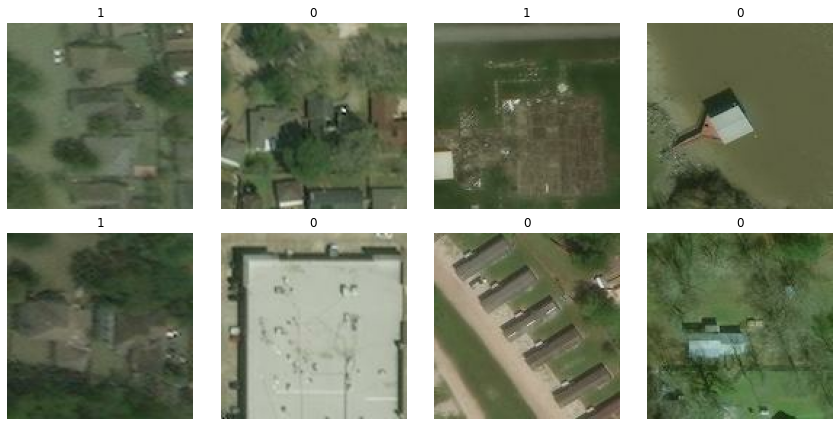

In [12]:
plt.figure(figsize=(12, 6))

for images, labels in train_ds.take(1):
    for i in range(8):
        ax = plt.subplot(2, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")
plt.tight_layout()

## If you want to apply data augmentation operations on the train dataset

Go to the `prepare_train_and_val_datasets(...)` and you can add augmentation operations directly to the train dataset as follows:

```
train_ds = (train_ds.map(lambda image, label: (tf.image.random_flip_left_right(image), label))
                    .map(lambda image, label: (tf.image.random_contrast(image, lower=0.2, upper=1.5), label))
                        .shuffle(2000)
                        .prefetch(buffer_size=tf.data.AUTOTUNE))
```


Remember to check [`tf.image`](https://www.tensorflow.org/api_docs/python/tf/image#image_adjustments) for various image transforms available and you can play around with augmentations

__Be careful here and don't add too many transforms which can distort the images beyond recognition__

In [13]:
train_ds = (train_ds.map(lambda image, label: (tf.image.random_flip_left_right(image), label))
                    .map(lambda image, label: (tf.image.random_contrast(image, lower=0.2, upper=1.5), label))
                        .shuffle(2000)
                        .prefetch(buffer_size=tf.data.AUTOTUNE))

In [14]:
"""train_ds = (train_ds.map(lambda image, label: (tf.image.random_flip_left_right(image), label))
                    .map(lambda image, label: (tf.image.rot90(image), label))
                    .map(lambda image, label: (tf.image.flip_up_down(image), label))
                    .map(lambda image, label: (tf.image.flip_left_right(image), label))
                        .shuffle(2000)
                        .prefetch(buffer_size=tf.data.AUTOTUNE))"""

'train_ds = (train_ds.map(lambda image, label: (tf.image.random_flip_left_right(image), label))\n                    .map(lambda image, label: (tf.image.rot90(image), label))\n                    .map(lambda image, label: (tf.image.flip_up_down(image), label))\n                    .map(lambda image, label: (tf.image.flip_left_right(image), label))\n                        .shuffle(2000)\n                        .prefetch(buffer_size=tf.data.AUTOTUNE))'

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  


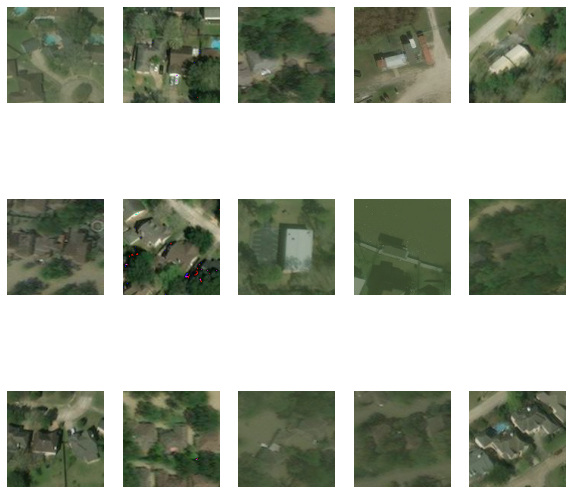

In [15]:
plt.figure(figsize=(10, 10))
for i in range(15):

  for images, _ in train_ds.take(i+1):
    #augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 5, i + 1)
    plt.imshow(images[0].numpy().astype("uint8"))
    plt.axis("off")


# BASE CNN MODEL

In [16]:
model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(128, 128, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(256, activation='relu'),
  layers.Dense(1, activation='sigmoid')
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 128, 128, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 128, 128, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 32, 32, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 32, 64)        1

In [17]:
LR = 0.0005

# callbacks
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                      patience=10,
                                      restore_best_weights=True,
                                      verbose=1)


model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=LR),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

In [18]:
from tensorflow.python.framework.random_seed import set_seed

tf.random.set_seed(42) # does this work????

epochs=100
history = model.fit(
  train_ds,
  validation_data=val_ds,
  callbacks=[es], 
  epochs=epochs
)

Epoch 1/100
34/34 [==============================] - 12s 28ms/step - loss: 0.6844 - accuracy: 0.5437 - val_loss: 0.6331 - val_accuracy: 0.5720
Epoch 2/100
34/34 [==============================] - 1s 15ms/step - loss: 0.6816 - accuracy: 0.5676 - val_loss: 0.6491 - val_accuracy: 0.5424
Epoch 3/100
34/34 [==============================] - 1s 15ms/step - loss: 0.6367 - accuracy: 0.5952 - val_loss: 0.5360 - val_accuracy: 0.8192
Epoch 4/100
34/34 [==============================] - 1s 15ms/step - loss: 0.5873 - accuracy: 0.6789 - val_loss: 0.5795 - val_accuracy: 0.7048
Epoch 5/100
34/34 [==============================] - 1s 15ms/step - loss: 0.5964 - accuracy: 0.6716 - val_loss: 0.5450 - val_accuracy: 0.7786
Epoch 6/100
34/34 [==============================] - 1s 15ms/step - loss: 0.5922 - accuracy: 0.6651 - val_loss: 0.5189 - val_accuracy: 0.7011
Epoch 7/100
34/34 [==============================] - 1s 15ms/step - loss: 0.5550 - accuracy: 0.7351 - val_loss: 0.4504 - val_accuracy: 0.8376
Epoch

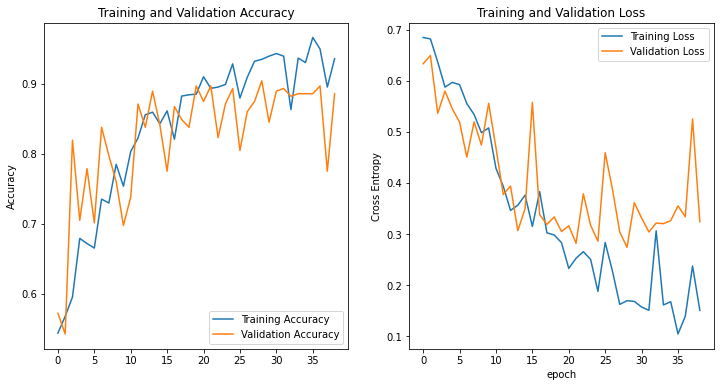

In [19]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [20]:
test_labels, predictions = eval_model_on_test(model)
predictions = np.where(predictions > 0.5, 1, 0)
print(classification_report(test_labels, predictions))
pd.DataFrame(confusion_matrix(test_labels, predictions))

Found 12228 files belonging to 2 classes.


Predicting on Test Data: 100%|██████████| 96/96 [00:09<00:00, 10.38it/s]

              precision    recall  f1-score   support

           0       0.86      0.89      0.87      6333
           1       0.87      0.84      0.86      5895

    accuracy                           0.87     12228
   macro avg       0.87      0.86      0.86     12228
weighted avg       0.87      0.87      0.87     12228



,0,1
0,5606,727
1,921,4974


# CNN WITH DROPOUT

In [21]:
model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(128, 128, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(256, activation='relu'),
  layers.Dense(1, activation='sigmoid')
])

print(model.summary())


# callbacks
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                      patience=10,
                                      restore_best_weights=True,
                                      verbose=1)


model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=LR),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

epochs=100
history = model.fit(
  train_ds,
  validation_data=val_ds,
  callbacks=[es], 
  epochs=epochs
)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 128, 128, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 128, 128, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 64, 64, 16)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 64, 64, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 32, 32, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 32, 32, 64)       

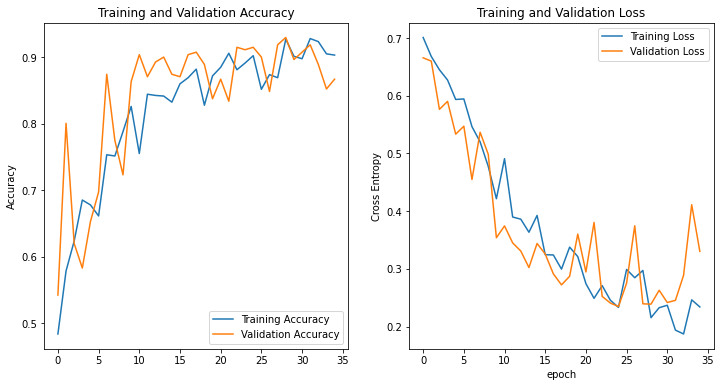

In [22]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [23]:
test_labels, predictions = eval_model_on_test(model)
predictions = np.where(predictions > 0.5, 1, 0)
print(classification_report(test_labels, predictions))
pd.DataFrame(confusion_matrix(test_labels, predictions))

Found 12228 files belonging to 2 classes.


Predicting on Test Data: 100%|██████████| 96/96 [00:09<00:00, 10.59it/s]


              precision    recall  f1-score   support

           0       0.92      0.85      0.89      6333
           1       0.85      0.92      0.89      5895

    accuracy                           0.89     12228
   macro avg       0.89      0.89      0.89     12228
weighted avg       0.89      0.89      0.89     12228



,0,1
0,5406,927
1,452,5443


# RESNET 50

In [24]:
model_trained = 'resnet50_v01'

# load a new instance of the model.
model_trained = tf.keras.applications.resnet50.ResNet50(input_shape=(128,128,3),
                                              include_top=False,
                                              weights='imagenet',
                                                     )

94781440/94765736 [==============================] - 1s 0us/step


In [25]:
for layer in model_trained.layers[-5:]:
  print(layer.name)

conv5_block3_2_relu
conv5_block3_3_conv
conv5_block3_3_bn
conv5_block3_add
conv5_block3_out


In [26]:
# points to last layer
last_conv_layer = model_trained.get_layer('conv5_block3_out')

In [27]:
conv_model = Model(inputs=model_trained.input,
                   outputs=last_conv_layer.output)

# Start a new Keras Sequential model.
model_resnet50 = Sequential()

# Add the convolutional part of the model from above.
model_resnet50.add(conv_model)

# the resnet model uses a global average pooling layer before the final dense layer
# other models may just flatten the final convolutional layer or 
# use other pooling layers so make sure to check the original model architecture
model_resnet50.add(tf.keras.layers.GlobalAveragePooling2D())

# Add a final dense (aka. fully-connected) layer.
# This is for combining features recognized in the image and calculating predictions 
# note that the number of nodes is the sameas the number of classes 
model_resnet50.add(tf.keras.layers.Dense(1, activation='sigmoid'))

# you could experiment with adding other layers like a dropout-layer which may prevent overfitting 
# but we will exclude this for now and stick to the original model architecture

In [28]:
# callbacks
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                      patience=10,
                                      restore_best_weights=True,
                                      verbose=1)


model_resnet50.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0003),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

In [29]:
conv_model.trainable = False
model_resnet50.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model (Functional)          (None, 4, 4, 2048)        23587712  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense_4 (Dense)             (None, 1)                 2049      
                                                                 
Total params: 23,589,761
Trainable params: 2,049
Non-trainable params: 23,587,712
_________________________________________________________________


In [30]:
initial_epoch = 100

history = model_resnet50.fit(
  train_ds,
  validation_data=val_ds,
  callbacks=[es], 
  epochs=initial_epoch
)


Epoch 1/100
34/34 [==============================] - 14s 212ms/step - loss: 0.2121 - accuracy: 0.9126 - val_loss: 183.4585 - val_accuracy: 0.5424
Epoch 2/100
34/34 [==============================] - 5s 133ms/step - loss: 0.0782 - accuracy: 0.9770 - val_loss: 229.8593 - val_accuracy: 0.5535
Epoch 3/100
34/34 [==============================] - 5s 137ms/step - loss: 0.0991 - accuracy: 0.9650 - val_loss: 1.1112 - val_accuracy: 0.8893
Epoch 4/100
34/34 [==============================] - 5s 137ms/step - loss: 0.0349 - accuracy: 0.9844 - val_loss: 0.3504 - val_accuracy: 0.9594
Epoch 5/100
34/34 [==============================] - 5s 134ms/step - loss: 0.0228 - accuracy: 0.9963 - val_loss: 0.4528 - val_accuracy: 0.9041
Epoch 6/100
34/34 [==============================] - 5s 135ms/step - loss: 0.0487 - accuracy: 0.9862 - val_loss: 1.1971 - val_accuracy: 0.7675
Epoch 7/100
34/34 [==============================] - 5s 138ms/step - loss: 0.0488 - accuracy: 0.9844 - val_loss: 0.2221 - val_accuracy: 0

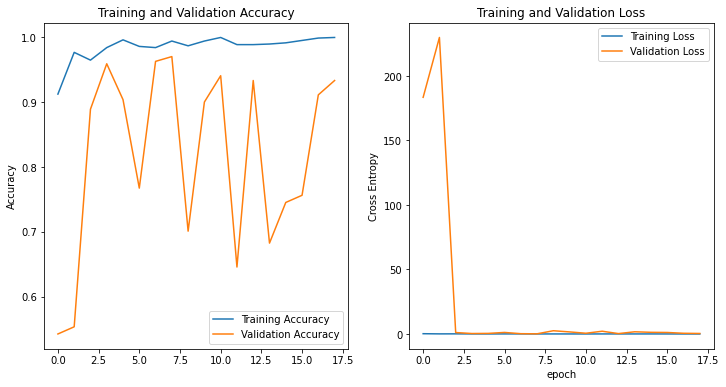

In [31]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [32]:
test_labels, predictions = eval_model_on_test(model_resnet50)
predictions = np.where(predictions > 0.5, 1, 0)
print(classification_report(test_labels, predictions))
pd.DataFrame(confusion_matrix(test_labels, predictions))

Found 12228 files belonging to 2 classes.


Predicting on Test Data: 100%|██████████| 96/96 [00:22<00:00,  4.30it/s]


              precision    recall  f1-score   support

           0       0.96      0.97      0.96      6333
           1       0.97      0.96      0.96      5895

    accuracy                           0.96     12228
   macro avg       0.96      0.96      0.96     12228
weighted avg       0.96      0.96      0.96     12228



,0,1
0,6134,199
1,260,5635


# RESNET 50 TUNING

In [33]:
conv_model.trainable = True

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in conv_model.layers[:fine_tune_at]:
  layer.trainable =  False
for layer in conv_model.layers:
    print(layer.name, '->', layer.trainable)

input_1 -> False
conv1_pad -> False
conv1_conv -> False
conv1_bn -> False
conv1_relu -> False
pool1_pad -> False
pool1_pool -> False
conv2_block1_1_conv -> False
conv2_block1_1_bn -> False
conv2_block1_1_relu -> False
conv2_block1_2_conv -> False
conv2_block1_2_bn -> False
conv2_block1_2_relu -> False
conv2_block1_0_conv -> False
conv2_block1_3_conv -> False
conv2_block1_0_bn -> False
conv2_block1_3_bn -> False
conv2_block1_add -> False
conv2_block1_out -> False
conv2_block2_1_conv -> False
conv2_block2_1_bn -> False
conv2_block2_1_relu -> False
conv2_block2_2_conv -> False
conv2_block2_2_bn -> False
conv2_block2_2_relu -> False
conv2_block2_3_conv -> False
conv2_block2_3_bn -> False
conv2_block2_add -> False
conv2_block2_out -> False
conv2_block3_1_conv -> False
conv2_block3_1_bn -> False
conv2_block3_1_relu -> False
conv2_block3_2_conv -> False
conv2_block3_2_bn -> False
conv2_block3_2_relu -> False
conv2_block3_3_conv -> False
conv2_block3_3_bn -> False
conv2_block3_add -> False
con

In [34]:
# callbacks
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                      patience=10,
                                      restore_best_weights=True,
                                      verbose=1)


model_resnet50.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0003/10),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

In [35]:
fine_tune_epochs = 100
total_epochs =  initial_epoch + fine_tune_epochs

history = model_resnet50.fit(
  train_ds,
  validation_data=val_ds,
  callbacks=[es], 
  initial_epoch = history.epoch[-1],
  epochs=total_epochs
)


Epoch 18/200
34/34 [==============================] - 8s 117ms/step - loss: 0.0366 - accuracy: 0.9917 - val_loss: 0.1057 - val_accuracy: 0.9705
Epoch 19/200
34/34 [==============================] - 3s 83ms/step - loss: 0.0138 - accuracy: 0.9954 - val_loss: 0.1082 - val_accuracy: 0.9742
Epoch 20/200
34/34 [==============================] - 3s 84ms/step - loss: 0.0088 - accuracy: 0.9963 - val_loss: 0.1174 - val_accuracy: 0.9705
Epoch 21/200
34/34 [==============================] - 3s 83ms/step - loss: 0.0132 - accuracy: 0.9954 - val_loss: 0.1296 - val_accuracy: 0.9705
Epoch 22/200
34/34 [==============================] - 3s 83ms/step - loss: 0.0049 - accuracy: 0.9991 - val_loss: 0.1177 - val_accuracy: 0.9705
Epoch 23/200
34/34 [==============================] - 3s 84ms/step - loss: 0.0040 - accuracy: 0.9991 - val_loss: 0.1173 - val_accuracy: 0.9705
Epoch 24/200
34/34 [==============================] - 3s 83ms/step - loss: 0.0040 - accuracy: 1.0000 - val_loss: 0.1192 - val_accuracy: 0.966

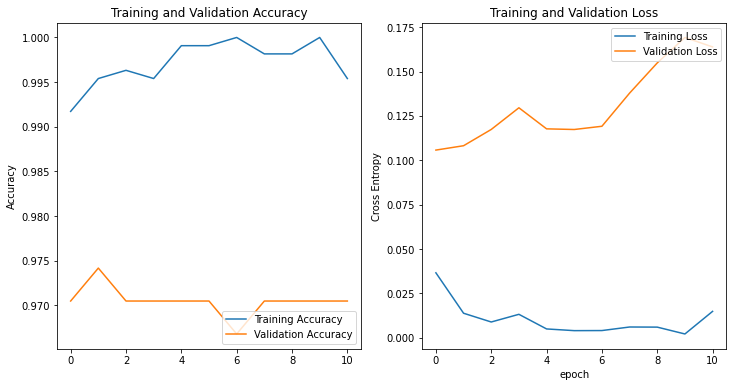

In [36]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [37]:
test_labels, predictions = eval_model_on_test(model_resnet50)
predictions = np.where(predictions > 0.5, 1, 0)
print(classification_report(test_labels, predictions))
pd.DataFrame(confusion_matrix(test_labels, predictions))

Found 12228 files belonging to 2 classes.


Predicting on Test Data: 100%|██████████| 96/96 [00:22<00:00,  4.34it/s]


              precision    recall  f1-score   support

           0       0.95      0.97      0.96      6333
           1       0.97      0.95      0.96      5895

    accuracy                           0.96     12228
   macro avg       0.96      0.96      0.96     12228
weighted avg       0.96      0.96      0.96     12228



,0,1
0,6169,164
1,292,5603


# MOBILE NET MODEL

In [38]:
# Create the base model from the pre-trained model MobileNet V2
model_trained = tf.keras.applications.MobileNetV2(input_shape=(128,128,3),
                                               include_top=False,
                                               weights='imagenet')

for layer in model_trained.layers[-5:]:
  print(layer.name)

# points to last layer
last_conv_layer = model_trained.get_layer('out_relu')

9420800/9406464 [==============================] - 0s 0us/step
block_16_project
block_16_project_BN
Conv_1
Conv_1_bn
out_relu


In [39]:
# Create the base model from the pre-trained model MobileNet V2
model_trained = tf.keras.applications.MobileNetV2(input_shape=(128,128,3),
                                               include_top=False,
                                               weights='imagenet')

model_trained.trainable = False


In [40]:
image_batch, label_batch = next(iter(train_ds))
feature_batch = model_trained(image_batch)
print(feature_batch.shape)

(32, 4, 4, 1280)


In [41]:
model_trained.trainable = False

In [42]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


In [43]:
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 1)


In [44]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [45]:
inputs = tf.keras.Input(shape=(128,128, 3))
x = preprocess_input(inputs)
x = model_trained(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model_mobile = tf.keras.Model(inputs, outputs)

In [46]:
# callbacks
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                      patience=10,
                                      restore_best_weights=True,
                                      verbose=1)


model_mobile.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0002),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

In [47]:
initial_epoch = 20

history = model_mobile.fit(
  train_ds,
  validation_data=val_ds,
  #callbacks=[es], 
  epochs=initial_epoch
)


Epoch 1/20
34/34 [==============================] - 5s 57ms/step - loss: 6.8979 - accuracy: 0.4315 - val_loss: 6.8348 - val_accuracy: 0.4317
Epoch 2/20
34/34 [==============================] - 1s 22ms/step - loss: 6.1654 - accuracy: 0.4361 - val_loss: 5.9804 - val_accuracy: 0.4539
Epoch 3/20
34/34 [==============================] - 1s 22ms/step - loss: 6.0340 - accuracy: 0.4554 - val_loss: 5.5826 - val_accuracy: 0.4760
Epoch 4/20
34/34 [==============================] - 1s 22ms/step - loss: 5.5783 - accuracy: 0.5124 - val_loss: 5.2254 - val_accuracy: 0.5203
Epoch 5/20
34/34 [==============================] - 1s 22ms/step - loss: 5.2669 - accuracy: 0.5207 - val_loss: 4.9290 - val_accuracy: 0.5387
Epoch 6/20
34/34 [==============================] - 1s 22ms/step - loss: 5.0216 - accuracy: 0.5382 - val_loss: 4.7758 - val_accuracy: 0.5609
Epoch 7/20
34/34 [==============================] - 1s 22ms/step - loss: 4.8416 - accuracy: 0.5851 - val_loss: 4.4779 - val_accuracy: 0.5720
Epoch 8/20
34

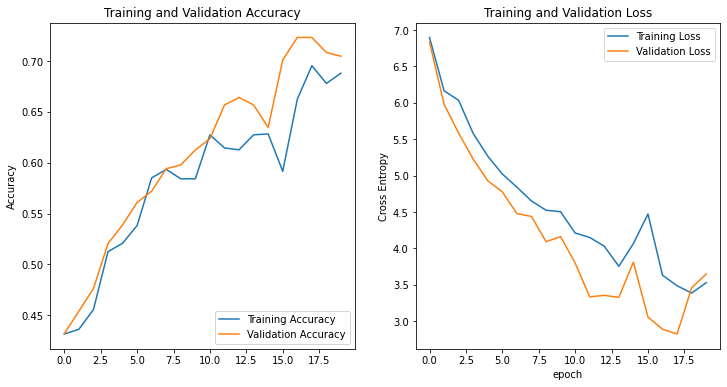

In [48]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [49]:
test_labels, predictions = eval_model_on_test(model_mobile)
predictions = np.where(predictions > 0.5, 1, 0)
print(classification_report(test_labels, predictions))
pd.DataFrame(confusion_matrix(test_labels, predictions))

Found 12228 files belonging to 2 classes.


Predicting on Test Data: 100%|██████████| 96/96 [00:13<00:00,  6.99it/s]


              precision    recall  f1-score   support

           0       0.63      0.94      0.76      6333
           1       0.87      0.41      0.55      5895

    accuracy                           0.68     12228
   macro avg       0.75      0.67      0.65     12228
weighted avg       0.74      0.68      0.66     12228



,0,1
0,5969,364
1,3502,2393


# MOBILE NET MODEL TUNNING

In [50]:
model_trained.trainable = True

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in model_trained.layers[:fine_tune_at]:
  layer.trainable =  False
for layer in model_trained.layers:
    print(layer.name, '->', layer.trainable)

input_3 -> False
Conv1 -> False
bn_Conv1 -> False
Conv1_relu -> False
expanded_conv_depthwise -> False
expanded_conv_depthwise_BN -> False
expanded_conv_depthwise_relu -> False
expanded_conv_project -> False
expanded_conv_project_BN -> False
block_1_expand -> False
block_1_expand_BN -> False
block_1_expand_relu -> False
block_1_pad -> False
block_1_depthwise -> False
block_1_depthwise_BN -> False
block_1_depthwise_relu -> False
block_1_project -> False
block_1_project_BN -> False
block_2_expand -> False
block_2_expand_BN -> False
block_2_expand_relu -> False
block_2_depthwise -> False
block_2_depthwise_BN -> False
block_2_depthwise_relu -> False
block_2_project -> False
block_2_project_BN -> False
block_2_add -> False
block_3_expand -> False
block_3_expand_BN -> False
block_3_expand_relu -> False
block_3_pad -> False
block_3_depthwise -> False
block_3_depthwise_BN -> False
block_3_depthwise_relu -> False
block_3_project -> False
block_3_project_BN -> False
block_4_expand -> False
block

In [51]:
# callbacks
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                      patience=10,
                                      restore_best_weights=True,
                                      verbose=1)


model_mobile.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001/10),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

In [52]:
model_mobile.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 128, 128, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 128, 128, 3)      0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_128 (Funct  (None, 4, 4, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d_1   (None, 1280)             0         
 (GlobalAveragePooling2D)                                  

In [53]:
fine_tune_epochs = 100
total_epochs =  initial_epoch + fine_tune_epochs

history = model_mobile.fit(
  train_ds,
  validation_data=val_ds,
  callbacks=[es], 
  initial_epoch = history.epoch[-1],
  epochs=total_epochs
)


Epoch 20/120
34/34 [==============================] - 6s 59ms/step - loss: 3.2976 - accuracy: 0.7157 - val_loss: 2.4327 - val_accuracy: 0.7897
Epoch 21/120
34/34 [==============================] - 1s 29ms/step - loss: 3.3082 - accuracy: 0.7323 - val_loss: 2.9934 - val_accuracy: 0.7638
Epoch 22/120
34/34 [==============================] - 1s 29ms/step - loss: 2.6675 - accuracy: 0.7820 - val_loss: 3.4210 - val_accuracy: 0.7528
Epoch 23/120
34/34 [==============================] - 1s 30ms/step - loss: 2.8324 - accuracy: 0.7443 - val_loss: 2.0802 - val_accuracy: 0.8081
Epoch 24/120
34/34 [==============================] - 1s 29ms/step - loss: 3.7074 - accuracy: 0.7148 - val_loss: 6.5614 - val_accuracy: 0.5498
Epoch 25/120
34/34 [==============================] - 1s 29ms/step - loss: 6.2418 - accuracy: 0.5658 - val_loss: 4.5272 - val_accuracy: 0.6605
Epoch 26/120
34/34 [==============================] - 1s 29ms/step - loss: 3.0148 - accuracy: 0.7397 - val_loss: 2.4582 - val_accuracy: 0.7860

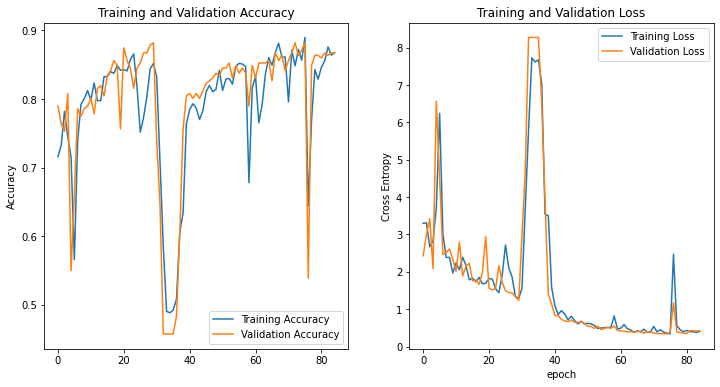

In [54]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [55]:
test_labels, predictions = eval_model_on_test(model_mobile)
predictions = np.where(predictions > 0.5, 1, 0)
print(classification_report(test_labels, predictions))
pd.DataFrame(confusion_matrix(test_labels, predictions))

Found 12228 files belonging to 2 classes.


Predicting on Test Data: 100%|██████████| 96/96 [00:13<00:00,  7.03it/s]

              precision    recall  f1-score   support

           0       0.85      0.92      0.88      6333
           1       0.91      0.82      0.86      5895

    accuracy                           0.87     12228
   macro avg       0.88      0.87      0.87     12228
weighted avg       0.88      0.87      0.87     12228



,0,1
0,5834,499
1,1036,4859


# RESNET 50 WITH DROPOUT

In [56]:
base_model = tf.keras.applications.ResNet50(input_shape=(128,128, 3),
                                            include_top=False,
                                            weights='imagenet')

image_batch, label_batch = next(iter(train_ds))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

base_model.trainable = False

global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

prediction_layer = tf.keras.layers.Dense(1, activation='sigmoid')
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

inputs = tf.keras.Input(shape=(128,128, 3))
#x = data_augmentation(inputs)
x = tf.keras.applications.resnet.preprocess_input(inputs)
x = base_model(x, training=False)  # important: training=False
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(256)(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)
model_resnet50_do = tf.keras.Model(inputs, outputs)


model_resnet50_do.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

model_resnet50_do.summary()

(32, 4, 4, 2048)
(32, 2048)
(32, 1)
Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 tf.__operators__.getitem (S  (None, 128, 128, 3)      0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 128, 128, 3)      0         
                                                                 
 resnet50 (Functional)       (None, 4, 4, 2048)        23587712  
                                                                 
 global_average_pooling2d_3   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_7 (Dense)       

In [57]:
initial_epoch = 30

history = model_resnet50_do.fit(
  train_ds,
  validation_data=val_ds,
  #callbacks=[es], 
  epochs=initial_epoch
)


Epoch 1/30
34/34 [==============================] - 6s 77ms/step - loss: 0.4996 - accuracy: 0.7783 - val_loss: 0.2511 - val_accuracy: 0.9041
Epoch 2/30
34/34 [==============================] - 2s 50ms/step - loss: 0.2711 - accuracy: 0.8887 - val_loss: 0.2195 - val_accuracy: 0.9041
Epoch 3/30
34/34 [==============================] - 2s 50ms/step - loss: 0.2088 - accuracy: 0.9190 - val_loss: 0.2218 - val_accuracy: 0.9114
Epoch 4/30
34/34 [==============================] - 2s 50ms/step - loss: 0.1899 - accuracy: 0.9273 - val_loss: 0.1982 - val_accuracy: 0.9299
Epoch 5/30
34/34 [==============================] - 2s 50ms/step - loss: 0.1557 - accuracy: 0.9402 - val_loss: 0.1861 - val_accuracy: 0.9299
Epoch 6/30
34/34 [==============================] - 2s 50ms/step - loss: 0.1532 - accuracy: 0.9448 - val_loss: 0.1927 - val_accuracy: 0.9299
Epoch 7/30
34/34 [==============================] - 2s 50ms/step - loss: 0.1310 - accuracy: 0.9457 - val_loss: 0.1817 - val_accuracy: 0.9299
Epoch 8/30
34

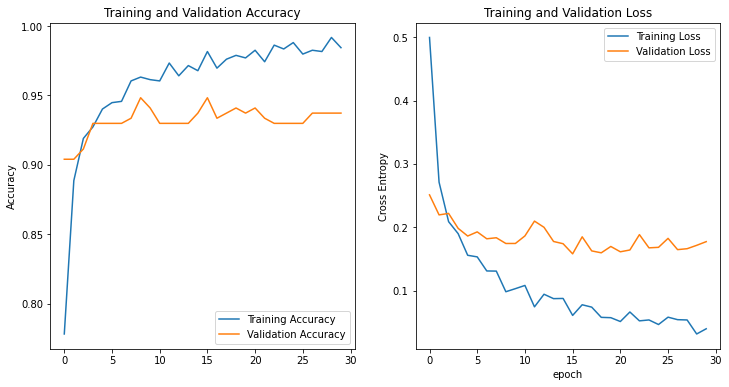

In [58]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [59]:
test_labels, predictions = eval_model_on_test(model_resnet50_do)
predictions = np.where(predictions > 0.5, 1, 0)
print(classification_report(test_labels, predictions))
pd.DataFrame(confusion_matrix(test_labels, predictions))

Found 12228 files belonging to 2 classes.


Predicting on Test Data: 100%|██████████| 96/96 [00:22<00:00,  4.34it/s]

              precision    recall  f1-score   support

           0       0.95      0.93      0.94      6333
           1       0.92      0.94      0.93      5895

    accuracy                           0.93     12228
   macro avg       0.93      0.93      0.93     12228
weighted avg       0.93      0.93      0.93     12228



,0,1
0,5870,463
1,337,5558


# RESNET 50 W/ DROPOUT TUNNING

In [60]:
base_model.trainable = True
# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

  

In [61]:
# callbacks
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                      patience=10,
                                      restore_best_weights=True,
                                      verbose=1)


model_resnet50_do.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001/10),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

model_resnet50_do.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 tf.__operators__.getitem (S  (None, 128, 128, 3)      0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 128, 128, 3)      0         
                                                                 
 resnet50 (Functional)       (None, 4, 4, 2048)        23587712  
                                                                 
 global_average_pooling2d_3   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_7 (Dense)             (None, 256)               5245

In [62]:
fine_tune_epochs = 100
total_epochs =  initial_epoch + fine_tune_epochs

history = model_resnet50_do.fit(
  train_ds,
  validation_data=val_ds,
  callbacks=[es], 
  initial_epoch = history.epoch[-1],
  epochs=total_epochs
)


Epoch 30/130
34/34 [==============================] - 8s 117ms/step - loss: 0.0374 - accuracy: 0.9880 - val_loss: 0.2681 - val_accuracy: 0.9225
Epoch 31/130
34/34 [==============================] - 3s 87ms/step - loss: 0.0441 - accuracy: 0.9880 - val_loss: 0.2048 - val_accuracy: 0.9410
Epoch 32/130
34/34 [==============================] - 3s 84ms/step - loss: 0.0184 - accuracy: 0.9972 - val_loss: 0.2568 - val_accuracy: 0.9299
Epoch 33/130
34/34 [==============================] - 3s 84ms/step - loss: 0.0351 - accuracy: 0.9880 - val_loss: 0.2448 - val_accuracy: 0.9262
Epoch 34/130
34/34 [==============================] - 3s 84ms/step - loss: 0.0195 - accuracy: 0.9936 - val_loss: 0.2407 - val_accuracy: 0.9262
Epoch 35/130
34/34 [==============================] - 3s 84ms/step - loss: 0.0195 - accuracy: 0.9945 - val_loss: 0.2687 - val_accuracy: 0.9262
Epoch 36/130
34/34 [==============================] - 3s 84ms/step - loss: 0.0121 - accuracy: 0.9954 - val_loss: 0.2258 - val_accuracy: 0.944

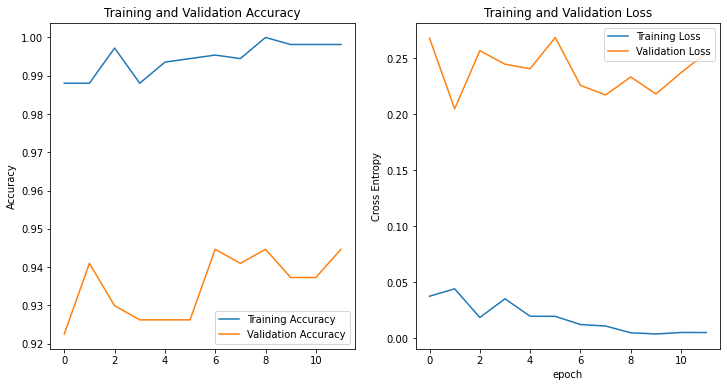

In [63]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [64]:
test_labels, predictions = eval_model_on_test(model_resnet50_do)
predictions = np.where(predictions > 0.5, 1, 0)
print(classification_report(test_labels, predictions))
pd.DataFrame(confusion_matrix(test_labels, predictions))

Found 12228 files belonging to 2 classes.


Predicting on Test Data: 100%|██████████| 96/96 [00:22<00:00,  4.24it/s]

              precision    recall  f1-score   support

           0       0.93      0.96      0.94      6333
           1       0.96      0.92      0.94      5895

    accuracy                           0.94     12228
   macro avg       0.94      0.94      0.94     12228
weighted avg       0.94      0.94      0.94     12228



,0,1
0,6087,246
1,491,5404
